In [2]:
import time
import survtreeshap as fstp
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from survshap import SurvivalModelExplainer, PredictSurvSHAP
import utils

from sksurv.util import Surv
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored

/home/ducrot/miniconda3/envs/env_survtreeshap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Génération des datasets
dfs = []
betas = []

for p in range(1, 15):
    df, beta = utils.simulate_cox_data(n_samples=500, n_features=p, random_state=42 + p)
    dfs.append(df)
    betas.append(beta)

In [4]:

y_kernel=[]
y_tree=[]
nb_var=[]
for i in range(1, 15):
    df=dfs[i]
    X = df.drop(columns=['time', 'event']).values
    X = pd.DataFrame(X, columns=[f"cov_{i}" for i in range(X.shape[1])])
    y = np.array(list(zip(df['event'].astype(bool), df['time'])),dtype=[('event', '?'), ('time', 'f8')])
    X = X.astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rsf = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=10, max_leaf_nodes=20).fit(X_train, y_train)

    # time KerneleSHAP

    explainer = SurvivalModelExplainer(model = rsf, data = X_train, y = y_train)
    observation_A = X_test.iloc[[0]]
    survshap_A = PredictSurvSHAP()

    start=time.time()
    survshap_A.fit(explainer = explainer, new_observation = observation_A) 
    y_kernel.append(time.time() - start)

    # time SurvTreeSHAP
    STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
    start=time.time()
    _=STS.computesurvshap(0)
    y_tree.append(time.time()- start)
        
    nb_var.append(i+1)



100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 589.00it/s]


IndexError: list index out of range

[]

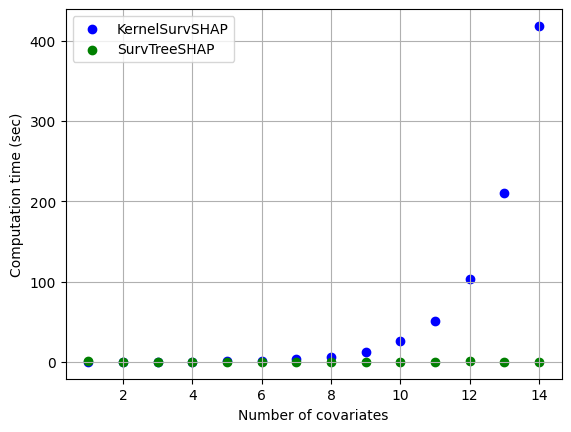

In [11]:
log_y_kernel=np.log(np.array(y_kernel))
#a, b = np.polyfit(nb_var, log_y_kernel, 1)
#x_fit = np.linspace(min(nb_var), max(nb_var), 100)
#y_fit = np.exp(b) * (np.exp(a)**x_fit)
plt.scatter(nb_var, y_kernel, color='blue', label="KernelSurvSHAP")
#plt.plot(x_fit, y_fit, color='blue', label=f"y = {int(np.exp(b)*1000)/1000} *({int(np.exp(a)*1000)/1000}**d)")

log_y_tree=np.log(np.array(y_tree))
#a, b = np.polyfit(t, y_tree, 1)
#x_fit = np.linspace(min(t), max(t), 100)
#y_fit = a * x_fit + b
plt.scatter(nb_var, y_tree, color='green', label="SurvTreeSHAP")
#plt.plot(x_fit, y_fit, color='green', label=f"y = {int(a*1000)/1000}d + {int(b*1000)/1000}")

plt.xlabel("Number of covariates")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.grid()
plt.plot() 